In [1]:
# 元コード（Qiita: 【Pytorch】MNISTのGAN（敵対的生成ネットワーク）を実装する）
# https://qiita.com/gensal/items/4be65d9b36fac02f877e#%E7%92%B0%E5%A2%83
# リファクタリング, コードの変更してます
# メニューのランタイムから、「ランタイムのタイプを変更」で、GPUを選択しましょう

In [2]:
# ライブラリのインポート
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST

In [3]:
# 学習データの読み込み
BATCH_SIZE = 32

train_data = MNIST(
    "./data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

print("train data size: ",len(train_data))
print("train iteration number: ",len(train_data)//BATCH_SIZE)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5961259.18it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 157099.96it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1486808.86it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4458349.82it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

train data size:  60000
train iteration number:  1875


images_size: torch.Size([32, 1, 28, 28])
label: tensor([7, 7, 1, 0, 4, 9, 0, 2, 6, 9, 1, 2, 1, 7, 4, 1, 4, 5, 9, 0, 0, 9, 8, 2,
        5, 4, 9, 5, 9, 2, 3, 0])


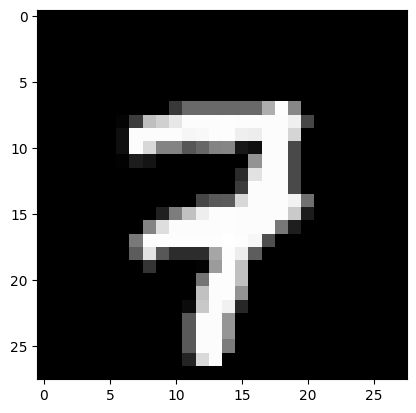

In [4]:
# 最初の画像を表示してみる
images, labels = next(iter(train_loader))
print("images_size:", images.size())
print("label:", labels)

image_numpy = images.detach().numpy().copy()
plt.imshow(image_numpy[0,0,:,:], cmap='gray')

In [5]:
# 生成器と識別器の定義
class TwoConvBlock_2D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding="same")
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.rl = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding="same")
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.rl(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.rl(x)
        return x

class Discriminator(nn.Module): # 識別器
    def __init__(self):
        super().__init__()
        self.conv1 = TwoConvBlock_2D(1, 64)
        self.conv2 = TwoConvBlock_2D(64, 128)
        self.conv3 = TwoConvBlock_2D(128, 256)

        self.maxpool_2D = nn.AvgPool2d(2, stride = 2)

        self.l1 = nn.Linear(2304, 100)
        self.l2 = nn.Linear(100, 1)
        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool_2D(x)
        x = self.conv2(x)
        x = self.maxpool_2D(x)
        x = self.conv3(x)
        x = self.maxpool_2D(x)
        x = x.view(-1, 2304)
        x = self.dropout(x)
        x = self.l1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.l2(x)
        x = torch.sigmoid(x)
        return x

class Generator(nn.Module): #生成器
    def __init__(self):
        super().__init__()
        self.TCB1 = TwoConvBlock_2D(1, 64)
        self.TCB2 = TwoConvBlock_2D(64, 128)
        self.TCB3 = TwoConvBlock_2D(128, 256)
        self.UC1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.UC2 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(256, 1, kernel_size=2, padding="same")

    def forward(self, x):
        x = self.TCB1(x)
        x = self.UC1(x)
        x = self.TCB2(x)
        x = self.UC2(x)
        x = self.TCB3(x)
        x = self.conv1(x)
        x = torch.sigmoid(x)
        return x


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(input, weight, bias, self.stride,


<Figure size 640x480 with 0 Axes>

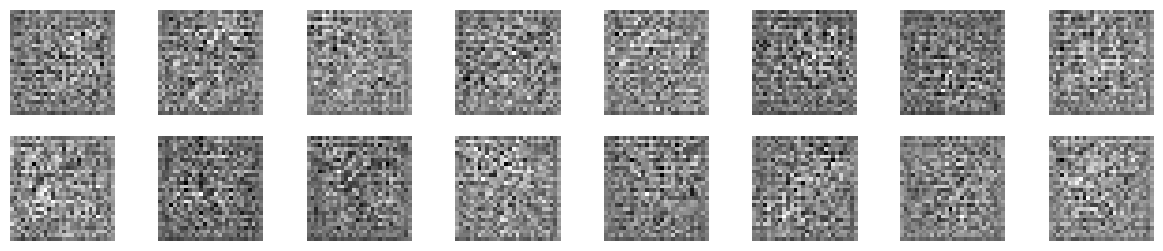

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


epoch:01, index:0001/1875  train_loss_D:0.04366065  train_loss_G:0.02322150
epoch:01, index:0626/1875  train_loss_D:0.00623138  train_loss_G:0.11553612
epoch:01, index:1251/1875  train_loss_D:0.00355505  train_loss_G:0.12160045


<Figure size 640x480 with 0 Axes>

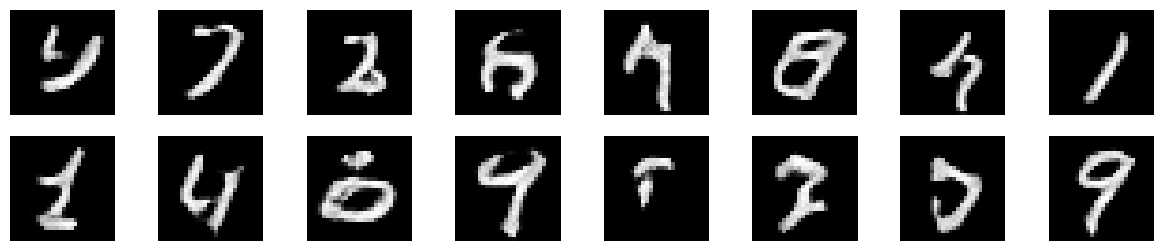

epoch:02, index:0001/1875  train_loss_D:0.00149128  train_loss_G:0.12291905
epoch:02, index:0626/1875  train_loss_D:0.00673162  train_loss_G:0.14109308
epoch:02, index:1251/1875  train_loss_D:0.01707819  train_loss_G:0.14202484


<Figure size 640x480 with 0 Axes>

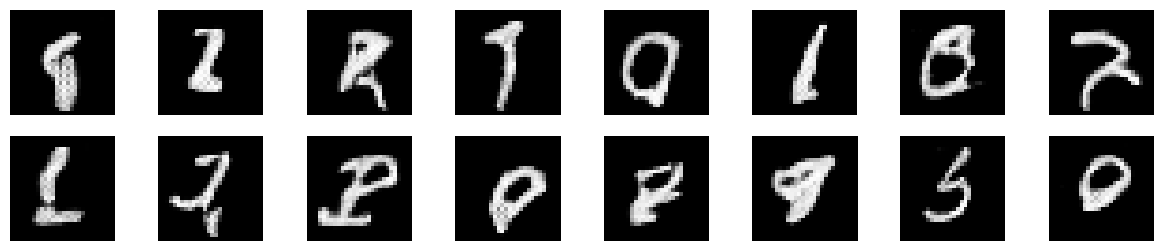

epoch:03, index:0001/1875  train_loss_D:0.02586906  train_loss_G:0.08487086
epoch:03, index:0626/1875  train_loss_D:0.00160377  train_loss_G:0.09548587
epoch:03, index:1251/1875  train_loss_D:0.00539960  train_loss_G:0.10058758


<Figure size 640x480 with 0 Axes>

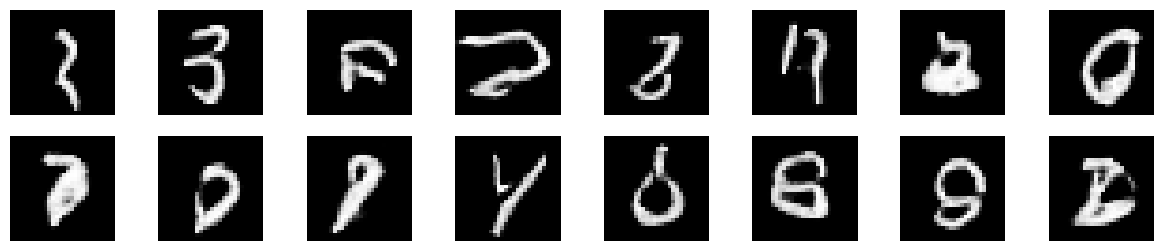

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_D = Discriminator().to(device)
model_G = Generator().to(device)

one_labels = torch.ones(BATCH_SIZE, 1).to(device)
zero_labels = torch.zeros(BATCH_SIZE, 1).to(device)

criterion = nn.BCELoss()

optimizer_D = optim.Adam(model_D.parameters(), lr=0.00001)
optimizer_G = optim.Adam(model_G.parameters(), lr=0.00001)

epoch_num = 3
G_train_ratio = 2 # 1epochで生成器が学習する回数

def show_image(epoch="0"):
    global model_G
    with torch.no_grad():
        batch_size = 16
        noise = torch.randn((batch_size, 1, 7, 7), dtype=torch.float32).to(device)
        syn_image = model_G(noise).to("cpu")
        syn_image = syn_image.detach().numpy().copy()

        plt.figure()
        fig, ax = plt.subplots(2, batch_size // 2, figsize=(15, 3))
        for i in range(batch_size // 2):
            ax[0, i].imshow(syn_image[i, 0, :, :], cmap='gray')
            ax[1, i].imshow(syn_image[i + batch_size // 2, 0, :, :], cmap='gray')
            ax[0, i].axis("off")
            ax[1, i].axis("off")
        plt.show()
show_image()

history = {"train_loss_D": [], "train_loss_G": []}
for epoch in range(epoch_num):
    model_D.train()
    model_G.train()
    for i, data in enumerate(train_loader):

        # 識別器の学習 - 本物のデータ
        optimizer_D.zero_grad()
        inputs = data[0].to(device)
        outputs = model_D(inputs)
        loss_real = criterion(outputs, one_labels)

        # 識別器の学習 - 偽物のデータ
        noise = torch.randn((BATCH_SIZE, 1, 7, 7), dtype=torch.float32).to(device)
        inputs_fake = model_G(noise)
        outputs_fake = model_D(inputs_fake.detach())
        loss_fake = criterion(outputs_fake, zero_labels)
        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # 生成器の学習
        for _ in range(G_train_ratio):
            optimizer_G.zero_grad()
            noise = torch.randn((BATCH_SIZE, 1, 7, 7), dtype=torch.float32).to(device)
            inputs_fake = model_G(noise)
            outputs_fake = model_D(inputs_fake)
            loss_G = criterion(outputs_fake, one_labels)
            loss_G.backward()
            optimizer_G.step()

        # 学習経過の保存
        train_loss_D = loss_D.item() / BATCH_SIZE
        train_loss_G = loss_G.item() / BATCH_SIZE
        history["train_loss_D"].append(train_loss_D)
        history["train_loss_G"].append(train_loss_G)

        # 指定したバッチ数ごとに過程を表示
        if i % (len(train_data) / BATCH_SIZE / 6) == 0:
            print(f"epoch:{epoch+1:02d}, index:{i+1:04d}/{int(len(train_data)/BATCH_SIZE)}  train_loss_D:{train_loss_D:.8f}  train_loss_G:{train_loss_G:.8f}")

    # エポックごとに画像を表示させる
    show_image(epoch)

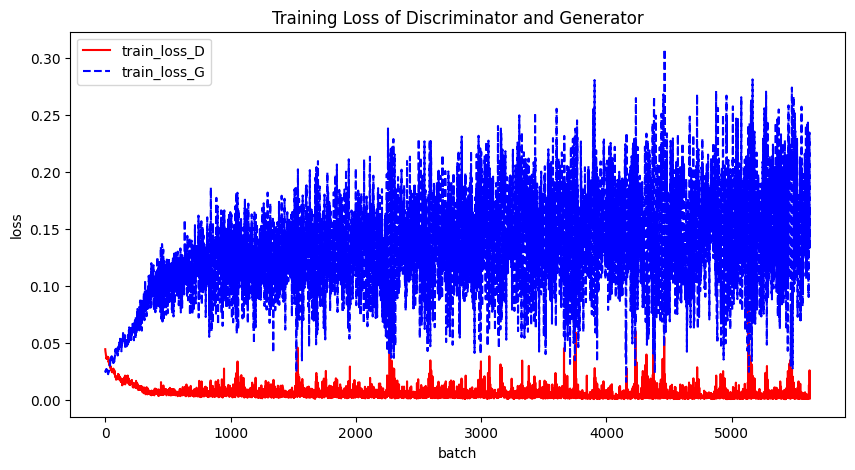

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history["train_loss_D"], label='train_loss_D', color='red', linestyle='-')
plt.plot(history["train_loss_G"], label='train_loss_G', color='blue', linestyle='--')

plt.xlabel('batch')
plt.ylabel('loss')
plt.title('Training Loss of Discriminator and Generator')
plt.legend()

plt.show()